In [25]:
from rich.progress import track

In [26]:
from model import ConvNeXt
from data import LeavesData

In [43]:
import pandas as pd

In [27]:
import torch
from torchvision import models
from torchmetrics import ConfusionMatrix

In [28]:
torch.set_float32_matmul_precision("high")

In [29]:
model = ConvNeXt(models.convnext_small)
model.load_state_dict(torch.load("ConvNeXt_Small_pretrained-epoch_20.pt"))

/usr/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

In [30]:
confmat = ConfusionMatrix(task='multiclass', num_classes=176)

In [31]:
model.to('cuda')
confmat.to('cuda')

MulticlassConfusionMatrix()

In [32]:
data = LeavesData(batch_size=32)
data.setup('test')

In [33]:
model.eval();

In [34]:
for X, y in track(data.test_dataloader()):
    X, y = X.to('cuda'), y.to('cuda')
    confmat(model(X), y)

Output()

In [35]:
del X, y
torch.cuda.empty_cache()

In [36]:
%matplotlib inline

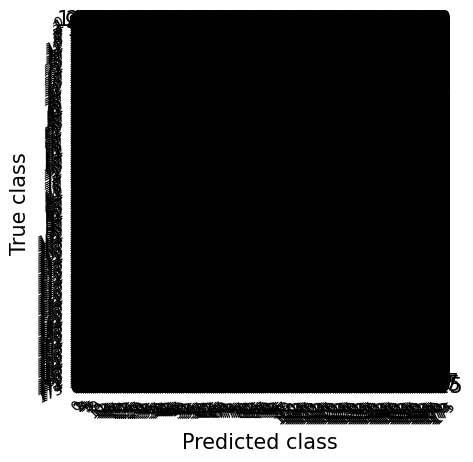

In [21]:
# confmat.plot();

In [37]:
res = confmat.compute()
res

tensor([[148,  23,   0,  ...,   0,   0,   0],
        [  0,  93,   0,  ...,   0,   0,   0],
        [  0,   0,  80,  ...,   0,   0,   0],
        ...,
        [  0,   0,   0,  ..., 187,   0,   1],
        [  0,   0,   0,  ...,   0, 235,   0],
        [  0,   0,   0,  ...,   0,   0, 115]], device='cuda:0')

In [38]:
error = res.clone()
error.fill_diagonal_(0)
error

tensor([[ 0, 23,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  1],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]], device='cuda:0')

In [49]:
values, indices = error.view(-1).topk(20)

In [50]:
values.tolist(), indices.tolist()

([93, 32, 30, 25, 24, 23, 20, 17, 12, 11, 9, 9, 8, 8, 5, 5, 5, 4, 4, 4],
 [22321,
  7115,
  2120,
  22834,
  20898,
  1,
  6763,
  14867,
  19820,
  6996,
  20702,
  18763,
  17675,
  19814,
  29381,
  6433,
  18938,
  17851,
  18230,
  18413])

In [51]:
real_indices = [(i // 176, i % 176) for i in indices.tolist()]
real_indices

[(126, 145),
 (40, 75),
 (12, 8),
 (129, 130),
 (118, 130),
 (0, 1),
 (38, 75),
 (84, 83),
 (112, 108),
 (39, 132),
 (117, 110),
 (106, 107),
 (100, 75),
 (112, 102),
 (166, 165),
 (36, 97),
 (107, 106),
 (101, 75),
 (103, 102),
 (104, 109)]

In [42]:
data.label_map[126], data.label_map[145]

('prunus_sargentii', 'quercus_muehlenbergii')

In [44]:
for value, index in zip(values.tolist(), real_indices):
    print(data.label_map[index[0]], data.label_map[index[1]], value, res[index[0], index[0]].item())

prunus_sargentii quercus_muehlenbergii 93 116
cedrus_libani larix_decidua 32 68
acer_saccharum acer_platanoides 30 85
prunus_subhirtella prunus_virginiana 25 76
pinus_virginiana prunus_virginiana 24 74
abies_concolor abies_nordmanniana 23 148
cedrus_atlantica larix_decidua 20 69
magnolia_tripetala magnolia_stellata 17 70
pinus_resinosa pinus_nigra 12 80
cedrus_deodara pseudolarix_amabilis 11 42


In [45]:
df = pd.DataFrame([
    [data.label_map[index[0]], res[index[0], index[0]].item(), data.label_map[index[1]], value]
    for value, index in zip(values.tolist(), real_indices)
], columns=("True label", "Corrects", "Predict label", "Wrongs"))

In [46]:
df

,True label,Corrects,Predict label,Wrongs
0,prunus_sargentii,116,quercus_muehlenbergii,93
1,cedrus_libani,68,larix_decidua,32
2,acer_saccharum,85,acer_platanoides,30
3,prunus_subhirtella,76,prunus_virginiana,25
4,pinus_virginiana,74,prunus_virginiana,24
5,abies_concolor,148,abies_nordmanniana,23
6,cedrus_atlantica,69,larix_decidua,20
7,magnolia_tripetala,70,magnolia_stellata,17
8,pinus_resinosa,80,pinus_nigra,12
9,cedrus_deodara,42,pseudolarix_amabilis,11


In [97]:
!cld "prunus sargentii"

 Prunus sargentii 大山樱（大山樱原产于日本北海道，属于蔷薇科李属，适合在寒冷地带栽培，观赏价值高。1972年，日本赠予中国作为礼品树，自然分布于日本、韩国、俄罗斯（库页岛）） 


In [96]:
!cld "quercus muehlenbergii"

 Quercus muehlenbergii 北美黄橡 


`prunus_sargentii` 有很多标记错误的图片，需要删除

In [100]:
print(df)

           True label  Corrects          Predict label  Wrongs
0    prunus_sargentii       116  quercus_muehlenbergii     186
1       cedrus_libani        68          larix_decidua      64
2      acer_saccharum        85       acer_platanoides      60
3  prunus_subhirtella        76      prunus_virginiana      50
4    pinus_virginiana        74      prunus_virginiana      48
5      abies_concolor       148     abies_nordmanniana      46
6    cedrus_atlantica        69          larix_decidua      40
7  magnolia_tripetala        70      magnolia_stellata      34
8      pinus_resinosa        80            pinus_nigra      24
9      cedrus_deodara        42   pseudolarix_amabilis      22


In [104]:
print(df.to_markdown())

|    | True label         |   Corrects | Predict label         |   Wrongs |
|---:|:-------------------|-----------:|:----------------------|---------:|
|  0 | prunus_sargentii   |        116 | quercus_muehlenbergii |      186 |
|  1 | cedrus_libani      |         68 | larix_decidua         |       64 |
|  2 | acer_saccharum     |         85 | acer_platanoides      |       60 |
|  3 | prunus_subhirtella |         76 | prunus_virginiana     |       50 |
|  4 | pinus_virginiana   |         74 | prunus_virginiana     |       48 |
|  5 | abies_concolor     |        148 | abies_nordmanniana    |       46 |
|  6 | cedrus_atlantica   |         69 | larix_decidua         |       40 |
|  7 | magnolia_tripetala |         70 | magnolia_stellata     |       34 |
|  8 | pinus_resinosa     |         80 | pinus_nigra           |       24 |
|  9 | cedrus_deodara     |         42 | pseudolarix_amabilis  |       22 |


In [107]:
from IPython.display import display

display(df)

,True label,Corrects,Predict label,Wrongs
0,prunus_sargentii,116,quercus_muehlenbergii,186
1,cedrus_libani,68,larix_decidua,64
2,acer_saccharum,85,acer_platanoides,60
3,prunus_subhirtella,76,prunus_virginiana,50
4,pinus_virginiana,74,prunus_virginiana,48
5,abies_concolor,148,abies_nordmanniana,46
6,cedrus_atlantica,69,larix_decidua,40
7,magnolia_tripetala,70,magnolia_stellata,34
8,pinus_resinosa,80,pinus_nigra,24
9,cedrus_deodara,42,pseudolarix_amabilis,22


In [111]:
df.to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>True label</th>\n      <th>Corrects</th>\n      <th>Predict label</th>\n      <th>Wrongs</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>prunus_sargentii</td>\n      <td>116</td>\n      <td>quercus_muehlenbergii</td>\n      <td>186</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>cedrus_libani</td>\n      <td>68</td>\n      <td>larix_decidua</td>\n      <td>64</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>acer_saccharum</td>\n      <td>85</td>\n      <td>acer_platanoides</td>\n      <td>60</td>\n    </tr>\n    <tr>\n      <th>3</th>\n      <td>prunus_subhirtella</td>\n      <td>76</td>\n      <td>prunus_virginiana</td>\n      <td>50</td>\n    </tr>\n    <tr>\n      <th>4</th>\n      <td>pinus_virginiana</td>\n      <td>74</td>\n      <td>prunus_virginiana</td>\n      <td>48</td>\n    </tr>\n    <tr>\n      <th>5</th>\n      <td>a

In [1]:
!cld "cedrus libani"

 Cedrus libani 黎巴嫩雪松 


In [3]:
!cld "larix decidua"

 larix decidua 欧洲落叶松 


无法区分 `cedrus_libani` 和 `larix_decidua`

In [4]:
!cld acer_saccharum

 Acer saccharum 糖枫：糖枫（学名：Acer saccharum Marshall）是一种北美洲硬木森林原产的树种，自加拿大新斯科舍省，向西分布至安大略省，并向南至美国乔治亚州及德州。 


In [5]:
!cld acer_platanoides

 Acer platanoides 挪威枫 


区别很细微：

- Acer saccharum = Sugar maple
- Acer platanoides = Norway maple

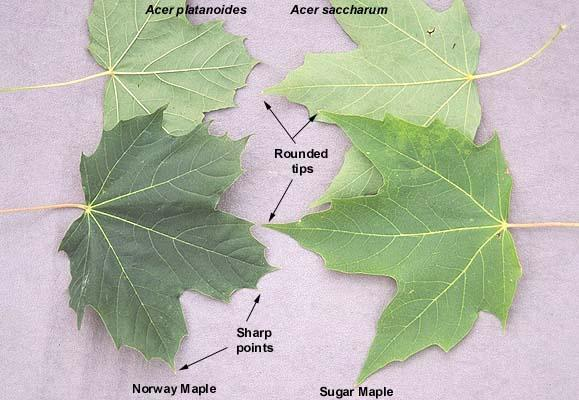

In [6]:
!cld prunus_subhirtella	

 日本早樱 日本早樱(Prunus subhirtella)：花叶同放，2～5朵形成伞形花序，花较大，白色，花梗有  毛，花萼绿色。 基于94个网页-相关网页 大叶早樱 我们为你提供安陆樱花 安陆2公分樱花价格的资讯信息，大叶早樱（Prunus subhirtella） 这一种樱花在国内的栽培要少于东京樱花和日本晚樱，但是它的一个变种Prunus subhirtella var. 基于56个网页-相关网页 江户彼岸樱 ...培育出来的品种，是日本为数最多的樱花品种，一般认为是日本原生种大岛樱（Prunus speciosa）与江户彼岸樱（Prunus subhirtella）的杂交品系，分别继承了两者花朵大和先花后叶的特点。 基于24个网页-相关网页 拉丁文 ...风， 一星期后再拿出来晒太阳；如果是地栽，先用遮阳网挡住阳光，一星期后，把遮阳网去掉。 樱花，拉丁文（Prunus subhirtella（Miq.）Sok. 基于18个网页-相关网页 短语 Prunus subhirtella Miq 早樱 Prunus subhirtella abstract: Prunus subhirtella (Prunus × subhirtella) sometimes also called Spring cherry, Higan cherry, or Rosebud cherryBailey, L.H. 


In [7]:
!cld prunus_virginiana

 prunus virginiana 野樱桃树 


In [8]:
!cld pinus_virginiana

 Pinus virginiana 矮松（矮松是中型树，高9-18米，树干直径半米，喜欢良好排水的土壤，在贫瘠及沙质土壤生长快但较矮） 


`prunus_virginiana` 有很多标记错误的图片，需要删除

`prunus_subhirtella` 和 `prunus_virginiana` 很难区分

In [12]:
df_p = pd.read_csv("plant_name.csv")

In [47]:
translation_map = {k: v for k, v in zip(df_p.iloc[:, 0], df_p.iloc[:, 1])}

In [22]:
lst = [1,2,3,4,5]
[(i, j:=i+1, j**2) for i in lst]

[(1, 2, 4), (2, 3, 9), (3, 4, 16), (4, 5, 25), (5, 6, 36)]

In [24]:
lst1 = [1,2,3]
lst2 = [(1,2),(3,4),(5,6)]
[(i,j,k) for i, (j, k) in zip(lst1, lst2)]

[(1, 1, 2), (2, 3, 4), (3, 5, 6)]

In [52]:
pd.DataFrame([
    [t:=data.label_map[index[0]], translation_map[t], res[index[0], index[0]].item(), f:=data.label_map[index[1]], translation_map[f], value]
    for value, index in zip(values.tolist(), real_indices)
], columns=("True label", "准确值", "Corrects", "Predict label", "预测值", "Wrongs"))

,True label,准确值,Corrects,Predict label,预测值,Wrongs
0,prunus_sargentii,山樱桃,116,quercus_muehlenbergii,毫毛栎,93
1,cedrus_libani,黎巴嫩雪松,68,larix_decidua,欧洲落叶松,32
2,acer_saccharum,糖枫,85,acer_platanoides,挪威枫,30
3,prunus_subhirtella,瘤果樱桃,76,prunus_virginiana,美国野樱桃,25
4,pinus_virginiana,弗吉尼亚松,74,prunus_virginiana,美国野樱桃,24
5,abies_concolor,白云杉,148,abies_nordmanniana,北美云杉,23
6,cedrus_atlantica,大西洋雪松,69,larix_decidua,欧洲落叶松,20
7,magnolia_tripetala,三瓣木兰,70,magnolia_stellata,星兰,17
8,pinus_resinosa,红松,80,pinus_nigra,黑松,12
9,cedrus_deodara,德奥达雪松,42,pseudolarix_amabilis,黄杉,11


In [53]:
%pip install imagehash

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple, https://mirrors.bfsu.edu.cn/pypi/web/simple, https://mirror.nju.edu.cn/pypi/web/simple, https://mirrors.pku.edu.cn/pypi/web/simple, https://pypi.nvidia.com
  Using cached https://mirrors.pku.edu.cn/pypi/web/packages/2d/b4/19a746a986c6e38595fa5947c028b1b8e287773dcad766e648897ad2a4cf/ImageHash-4.3.1-py2.py3-none-any.whl (296 kB)
  Using cached https://mirrors.pku.edu.cn/pypi/web/packages/79/a3/c13a5a01035e67def78aed4378993dcdce25650dab2e5117c16e1b7beccd/pywavelets-1.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.5 MB)


In [54]:
%pip list --local

Package           Version
----------------- -------
ImageHash         4.3.1
pip               23.3.2
PyWavelets        1.5.0
setuptools        69.0.2
torch-tb-profiler 0.4.3
Note: you may need to restart the kernel to use updated packages.


In [56]:
import imagehash
from PIL import Image

In [60]:
file1 = "./data/images_cleaned_train/magnolia_tripetala/2207.jpg"
file2 = "./data/images_cleaned_train/magnolia_stellata/4647.jpg"
with Image.open(file1) as img: hash1 = imagehash.average_hash(img)
with Image.open(file2) as img: hash2 = imagehash.average_hash(img)
hash1, hash2

(array([[ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True]]),
 array([[ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        

In [61]:
hash1 == hash2

True

In [64]:
import hashlib

In [66]:
hashlib.md5?

Signature: hashlib.md5(string=b'', *, usedforsecurity=True)
Docstring: Returns a md5 hash object; optionally initialized with a string
Type:      builtin_function_or_method